**Mount Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import Libraries**

In [51]:
!pip install fastai --upgrade -q

In [77]:
from fastai.vision.all import *

import PIL


In [4]:
!ls drive/'My Drive'/Dataset

COVID-19-20.zip  COVID-CT-master  CT1  CT2  DICOMDIR.zip  Radiogenomics  RFMID


In [5]:
path = Path('drive/My Drive/Dataset/RFMID')

### Get Data

In [6]:
df = pd.read_csv(path/'data/Training_Set/RFMiD_Training_Labels.csv')

In [7]:
df

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,LS,MS,CSR,ODC,CRVO,TV,AH,ODP,ODE,ST,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,OTHER
0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,1916,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1916,1917,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1917,1918,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1918,1919,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
path

Path('drive/My Drive/Dataset/RFMID')

In [9]:
batch_tfms = aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [50]:
classes = list(df.columns[2:])

In [14]:
def get_y(r): return r[classes].values.astype(np.int32)

In [44]:
 d_block = DataBlock(blocks=(ImageBlock,MultiCategoryBlock(encoded=True,vocab=classes)),
                    splitter=RandomSplitter(),
                    get_x=ColReader(0,pref=f'{path}/data/Training_Set/Training/', suff='.png'),
                    get_y=get_y)

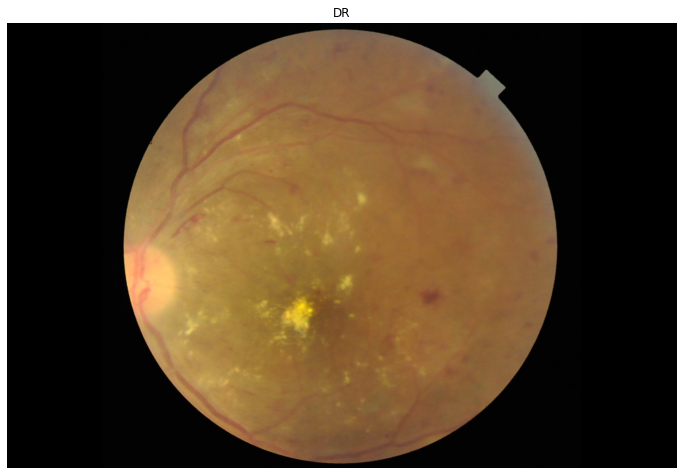

In [49]:
dls = d_block.dataloaders(df[:1],bs=1)
dls.show_batch(max_n=1, figsize=(12,9))

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

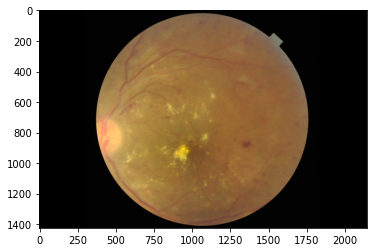

In [72]:
from PIL import Image
image = Image.open(path/'data/Training_Set/Training/1.png')
plt.imshow(image)
np.array(image)

## Custom Dataset

In [ ]:
https://docs.fast.ai/tutorial.siamese.html

In [80]:
def open_image(fname, size=1024):
    img = PIL.Image.open(fname)
    img = img.resize((size, size))
    t = torch.Tensor(np.array(img))
    return t.permute(2,0,1).float()/255.0

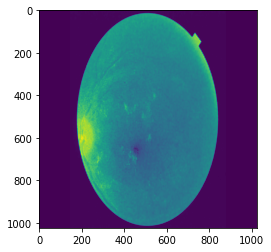

In [85]:
img = open_image(path/'data/Training_Set/Training/1.png')
plt.imshow(img[2,...])

## Train Model

In [52]:
from torchvision.models import resnet34

In [53]:
from fastai.metrics import accuracy_multi

In [86]:
learn = Learner(dls, xresnet34(c_in=3), metrics=[accuracy_multi])

In [87]:
class BCEWithLogitsLossFlat(BaseLoss):
    "Same as `nn.CrossEntropyLoss`, but flattens input and target."
    def __init__(self, *args, axis=-1, floatify=True, thresh=0.5, **kwargs):
        super().__init__(nn.BCEWithLogitsLoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)
        self.thresh = thresh

    def decodes(self, x):    return x>self.thresh
    def activation(self, x): return torch.sigmoid(x)

In [88]:
learn.loss_func = BCEWithLogitsLossFlat()

In [89]:
learn.lr_find()

ValueError: ignored

In [ ]:
lr = 1e-2
learn = learn.to_fp16()

In [ ]:
learn.fit_one_cycle(5, slice(lr))